# Mountain Car with gradient SARSA
---
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram. The difficulty is that gravity is stronger than the car’s engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left.

<img src="MountainCar.png" alt="drawing" width="300"/>

The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (01), and zero throttle (0). The car moves according to a simplified physics. Its position, `x_t`, and velocity, `x_ ̇t`, are updated by:

 <img src="update_rule.png" alt="drawing" width="500"/>

where the bound operation enforces `-1.2 <= x_t+1 <= 0.5` and `-0.07 <= x_ ̇t+1 <= 0.07`. In addition, when `x_t+1` reached the left bound, `x_ ̇t+1` was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. Each episode started from a random position `xt` in `[-0.6, -0.4)` and zero velocity.

---

# Semi-Gradient SARSA
---
<img src="semi-sarsa.png" alt="drawing" width="600"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from TileCoding import *
from mpl_toolkits.mplot3d import Axes3D

In [2]:
VELOCITY_BOUND = [-0.07, 0.07]
POSITION_BOUND = [-1.2, 0.5]
ACTIONS = [-1, 0, 1]

In [3]:
class ValueFunction:
    
    def __init__(self, stepSize, numOfTilings=8, maxSize=2048):
        self.maxSize = maxSize
        self.numOfTilings = numOfTilings

        # divide step size equally to each tiling
        self.stepSize = stepSize / numOfTilings  # learning rate for each tile

        self.hashTable = IHT(maxSize)

        # weight for each tile
        self.weights = np.zeros(maxSize)

        # position and velocity needs scaling to satisfy the tile software
        self.positionScale = self.numOfTilings / (POSITION_BOUND[1] - POSITION_BOUND[0])
        self.velocityScale = self.numOfTilings / (VELOCITY_BOUND[1] - VELOCITY_BOUND[0])

    # get indices of active tiles for given state and action
    def getActiveTiles(self, position, velocity, action):
        # I think positionScale * (position - position_min) would be a good normalization.
        # However positionScale * position_min is a constant, so it's ok to ignore it.
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.positionScale * position, self.velocityScale * velocity],
                            [action])
        return activeTiles

    # estimate the value of given state and action
    def value(self, position, velocity, action):
        if position == POSITION_BOUND[1]:
            return 0.0
        activeTiles = self.getActiveTiles(position, velocity, action)
        return np.sum(self.weights[activeTiles])

    # learn with given state, action and target
    def update(self, position, velocity, action, target):
        activeTiles = self.getActiveTiles(position, velocity, action)
        estimation = np.sum(self.weights[activeTiles])
        delta = self.stepSize * (target - estimation)
        for activeTile in activeTiles:
            self.weights[activeTile] += delta

    # get the # of steps to reach the goal under current state value function
    def costToGo(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)

In [4]:
class MountainCar:
    
    def __init__(self, n=1, exp_rate=0.1, gamma=1, debug=True):
        self.actions = [-1, 0, 1]  # reverse, 0 and forward throttle
        self.state = (-0.5, 0)  # position, velocity
        self.exp_rate = exp_rate
        self.gamma = gamma
        self.end = False
        self.n = n  # step of learning
        self.debug = debug
        
    def reset(self):
        pos = np.random.uniform(-0.6, -0.4)
        self.end = False
        self.state = (pos, 0)
        
    def takeAction(self, action):
        pos, vel = self.state
        
        vel_new = vel + 0.001*action - 0.0025*np.cos(3*pos)
        vel_new = min(max(vel_new, VELOCITY_BOUND[0]), VELOCITY_BOUND[1])
        
        pos_new = pos + vel_new
        pos_new = min(max(pos_new, POSITION_BOUND[0]), POSITION_BOUND[1])
        
        if pos_new == POSITION_BOUND[0]:
            # reach leftmost, set speed to 0
            vel_new = 0
        self.state = (pos_new, vel_new)
        return self.state
    
    def chooseAction(self, valueFunc):
        # choose an action based on the current state, 
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                pos, vel = self.state
                value = valueFunc.value(pos, vel, a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v==max(values.values())])
        
    def giveReward(self):
        pos, _ = self.state
        if pos == POSITION_BOUND[1]:
            self.end = True
            return 0
        return -1
        
    def play(self, valueFunction, rounds=1):
        for rnd in range(1, rounds+1):
            self.reset()
            t = 0
            T = np.inf
            action = self.chooseAction(valueFunction)
            
            actions = [action]
            states = [self.state]
            rewards = [-1]
            while True:
                if t < T:
                    state = self.takeAction(action)  # next state
                    reward = self.giveReward()  # next state-reward
                    
                    states.append(state)
                    rewards.append(reward)
                    
                    if self.end:
                        if self.debug:
                            if rnd % 500 == 0:
                                print("Round {}: End at state {} | number of states {}".format(rnd, state, len(states)))
                        T = t+1
                    else:
                        action = self.chooseAction(valueFunction)
                        actions.append(action)  # next action
                # state tau being updated
                tau = t - self.n + 1
                if tau >= 0:
                    G = 0
                    for i in range(tau+1, min(tau+self.n+1, T+1)):
                        G += np.power(self.gamma, i-tau-1)*rewards[i]
                    if tau+self.n < T:
                        state = states[tau+self.n]
                        G += np.power(self.gamma, self.n)*valueFunction.value(state[0], state[1], actions[tau+self.n])
                    # update value function
                    state = states[tau]  # tau is the state to update
                    
#                     print("update state {} | target {}".format(state, G))
                    valueFunction.update(state[0], state[1], actions[tau], G)
                    
                if tau == T-1:
                    break
                
                t += 1

In [5]:
stepSize = 0.3

In [6]:
valueFunc = ValueFunction(stepSize)
mc = MountainCar()
mc.play(valueFunc, rounds=9000)

Round 500: End at state (0.5, 0.029844695668130156) | number of states 145
Round 1000: End at state (0.5, 0.029833996819464945) | number of states 152
Round 1500: End at state (0.5, 0.029996860216211153) | number of states 119
Round 2000: End at state (0.5, 0.03156445606296692) | number of states 150
Round 2500: End at state (0.5, 0.02422406248085293) | number of states 172
Round 3000: End at state (0.5, 0.0184702707799283) | number of states 120
Round 3500: End at state (0.5, 0.02445391070759915) | number of states 151
Round 4000: End at state (0.5, 0.020321716305639035) | number of states 120
Round 4500: End at state (0.5, 0.0241896835954662) | number of states 114
Round 5000: End at state (0.5, 0.028353550097954493) | number of states 116
Round 5500: End at state (0.5, 0.02878859502698887) | number of states 149
Round 6000: End at state (0.5, 0.01225574860988486) | number of states 125
Round 6500: End at state (0.5, 0.008862936569865724) | number of states 141
Round 7000: End at sta

### Visualisation

Text(0.5, 0, 'Cost to go')

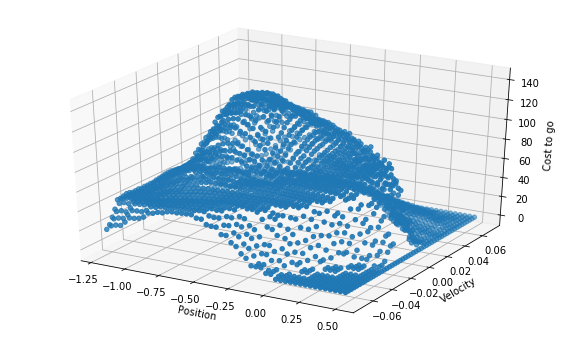

In [7]:
# step 100
grids = 50

positions = np.linspace(POSITION_BOUND[0], POSITION_BOUND[1], grids)
vels = np.linspace(VELOCITY_BOUND[0], VELOCITY_BOUND[1], grids)

x = []
y = []
z = []
for p in positions:
    for v in vels:
        x.append(p)
        y.append(v)
        z.append(valueFunc.costToGo(p, v))

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel("Position")
ax.set_ylabel("Velocity")
ax.set_zlabel("Cost to go")

Text(0.5, 0, 'Cost to go')

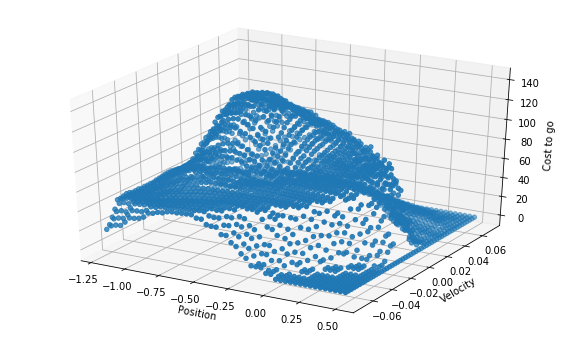

In [8]:
# step 9000
grids = 50

positions = np.linspace(POSITION_BOUND[0], POSITION_BOUND[1], grids)
vels = np.linspace(VELOCITY_BOUND[0], VELOCITY_BOUND[1], grids)

x = []
y = []
z = []
for p in positions:
    for v in vels:
        x.append(p)
        y.append(v)
        z.append(valueFunc.costToGo(p, v))

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

ax.set_xlabel("Position")
ax.set_ylabel("Velocity")
ax.set_zlabel("Cost to go")